In [1]:
from dataclasses import dataclass
import numpy as np


In [2]:
# Forward Clarke
@dataclass
class MotorCurrents:
  a: float
  b: float
  c: float
  def to_list(self):
    return [self.a, self.b, self.c]


@dataclass
class ClarkCurrents:
  alpha: float
  beta: float
  def to_list(self):
    return [self.alpha, self.beta]


@dataclass
class ParkCurrents:
  d: float
  q: float
  def to_list(self):
    return [self.d, self.q]


_SQRT_3 = 3**0.5
_SQRT_3_OVER_2 = _SQRT_3 / 2


def ForwardClark(i: MotorCurrents) -> ClarkCurrents:
  alpha = i.a
  beta = (i.b - i.c) / _SQRT_3
  return ClarkCurrents(alpha, beta)


def ForwardPark(i: ClarkCurrents, theta: float) -> ParkCurrents:
  cos_t = np.cos(theta)
  sin_t = np.sin(theta)
  i_d = i.alpha * cos_t + i.beta * sin_t
  i_q = -i.alpha * sin_t + i.beta * cos_t
  return ParkCurrents(d=i_d, q=i_q)


def ParkClark(i: MotorCurrents, theta: float) -> ParkCurrents:
  return ForwardPark(ForwardClark(i), theta)


def ReversePark(i: ParkCurrents, theta: float) -> ClarkCurrents:
  cos_t = np.cos(theta)
  sin_t = np.sin(theta)
  alpha = i.d * cos_t - i.q * sin_t
  beta = i.d * sin_t + i.q * cos_t
  return ClarkCurrents(alpha, beta)


def ReverseClark(i: ClarkCurrents) -> MotorCurrents:
  a = i.alpha
  b = -0.5 * i.alpha + _SQRT_3_OVER_2 * i.beta
  c = -0.5 * i.alpha - _SQRT_3_OVER_2 * i.beta
  return MotorCurrents(a, b, c)


def IParkClark(i: ParkCurrents, theta: float) -> MotorCurrents:
  return ReverseClark(ReversePark(i, theta))


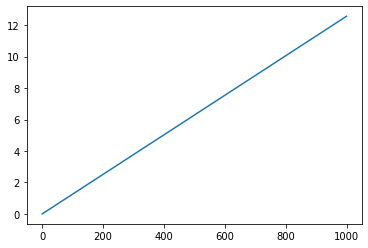

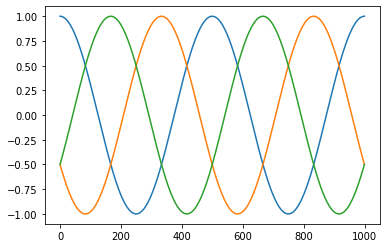

In [3]:
import matplotlib.pyplot as plt

thetas = np.linspace(0,4*np.pi,1000)

plt.plot(thetas)

class PerfectMotor:
  def currents(self, theta: float) -> MotorCurrents:
    a = np.cos(theta)
    b = np.cos(theta + np.pi * 2/3)
    c = np.cos(theta - np.pi * 2/3)
    return MotorCurrents(a,b,c)
  
  def clark_currents(self, theta: float):
    return ForwardClark(self.currents(theta))
  
  def park_currents(self, theta: float):
    return ForwardPark(ForwardClark(self.currents(theta)), -theta)

motor = PerfectMotor()

currents = [motor.currents(t) for t in thetas]

plt.figure()
plt.plot([c.to_list() for c in currents])

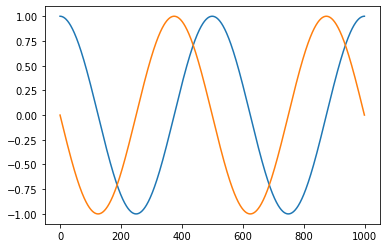

In [4]:
clarks = [motor.clark_currents(t) for t in thetas]
plt.plot([c.to_list() for c in clarks])

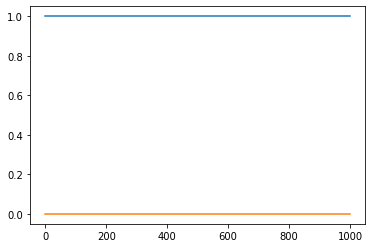

In [5]:
parks = [motor.park_currents(t) for t in thetas]
plt.plot([c.to_list() for c in parks])

# Now starting from torque, with non-perfect motors.

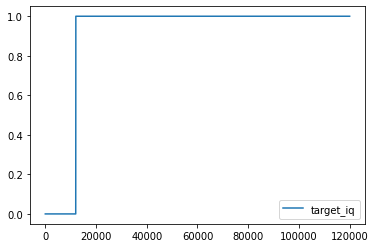

In [13]:
dt = 1 / 40000
duration = 3 # seconds

timesteps = int(duration / dt)
t = np.linspace(0, 10, timesteps)
desired_iq = np.zeros([timesteps])
desired_iq[int(0.1 * timesteps):] = 1

plt.plot(desired_iq)
plt.legend(['target_iq'])

In [45]:
print(int(0.1 * timesteps))

12000


0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0


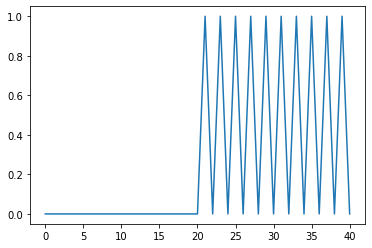

In [87]:
kp = 0.1
pd = 0.1

# class SimpleMotor:
#   def __init__(self, pole_pairs, encoder_resolution=4096, v_init=0):
#     self.pole_pairs = pole_pairs
#     self.encoder_resolution = encoder_resolution
#     self.elec_resolution = encoder_resolution // pole_pairs
#     self.phase_currents = {'a': 0, 'b': 0, 'c': 0}
#     self.velocity = v_init
  
class Controller:
  def __init__(self):
    self.currents = {'d': 0, 'q': 0}
    self.error_integrals = {'d': 0, 'q': 0}
  
  def follow_currents(self, target_q, target_d, kp, ki):
    # dt = 1/40000
    actual_q = []
    actual_d = []
    for idx, (t_q, t_d) in list(enumerate(zip(target_q, target_d)))[11900:12100]:
      i_q_err = t_q - self.currents['q']
      # i_d_err = t_d - self.currents['d']

      # self.error_integrals['d'] += i_d_err
      self.error_integrals['q'] += i_q_err
      self.currents['q'] = kp * i_q_err + ki #* self.error_integrals['q']
      # print(i_q_err, self.currents['q'])
      # self.currents['d'] = kp * i_d_err + ki #* self.error_integrals['d']
      actual_q.append(self.currents['q'])
      # actual_d.append(self.currents['d'])
    
    return (actual_q, actual_d)

  def follow_currents2(self, target_q, kp, ki):
    actual_q = []
    for t_q in target_q:
      i_q_err = t_q - self.currents['q']
      # self.error_integrals['q'] += i_q_err
      self.currents['q'] = kp * i_q_err #+ ki * self.error_integrals['q']
      actual_q.append(self.currents['q'])
    
    return actual_q

c = Controller()
i, q = c.follow_currents(desired_iq, np.zeros_like(desired_iq), 0.0001, 0.00001)

c = Controller()
i2 = c.follow_currents2(desired_iq, 0.2, 0)

def computePID(t, inp, kp):
  error = t - inp
  print(error, error * kp)
  return error * kp

i3 = [0]
for t in desired_iq[11980:12020]:
  i3.append(computePID(t, i3[-1], 1))

# plt.plot([desired_iq, i])
# plt.plot(desired_iq)
# plt.plot(i)
# plt.plot(i2)
plt.plot(i3)
# plt.legend(['target_iq', 'actual_i', 'actual_i2'])

